# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [1]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

from mlde_analysis.utils import chained_groupby_map
from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map, SUBREGIONS
from mlde_analysis.bootstrap import resample_examples
from mlde_analysis.ccs import compute_changes, plot_changes, plot_tp_fd, plot_hist_per_tp, plot_ccs_fc_figure, ccs_fc_da
from mlde_analysis.distribution import PER_GRIDBOX_QUANTILES, normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias, compute_metrics, DIST_THRESHOLDS
from mlde_analysis.fractional_contribution import compute_fractional_contribution, frac_contrib_change, fc_bins
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS
from mlde_analysis.display import VAR_RANGES, pretty_table
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS

In [2]:
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
from mlde_analysis.default_params import *

In [4]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [5]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [6]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [7]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

PRED_DAS = { var: xr.concat([ ds[f"pred_{var}"] for ds in EVAL_DS.values() ], dim="model") for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() } | {"CPM": {"source": "CPM", "color": "black"}}

In [8]:
CCS_SEASONS = ["DJF", "JJA"]

In [9]:
CCS_MODELS = {source: {model: spec for model, spec in mconfigs.items() if spec.get("CCS", False)} for source, mconfigs in MODELS.items() }

CCS_PRED_DAS = {var: PRED_DAS[var].sel(model=list([model for source, models in CCS_MODELS.items() for model in models])) for var in eval_vars }

CCS_DS = xr.combine_by_coords([*list(CPM_DAS.values()), *list(CCS_PRED_DAS.values())])

## Figure: per Time Period per season fractional contribution

* Fractional contribution of rainfall intensities for each time period and season
* Change in fractional contribution of rainfall intensities from historic to future for each season

#### DJF

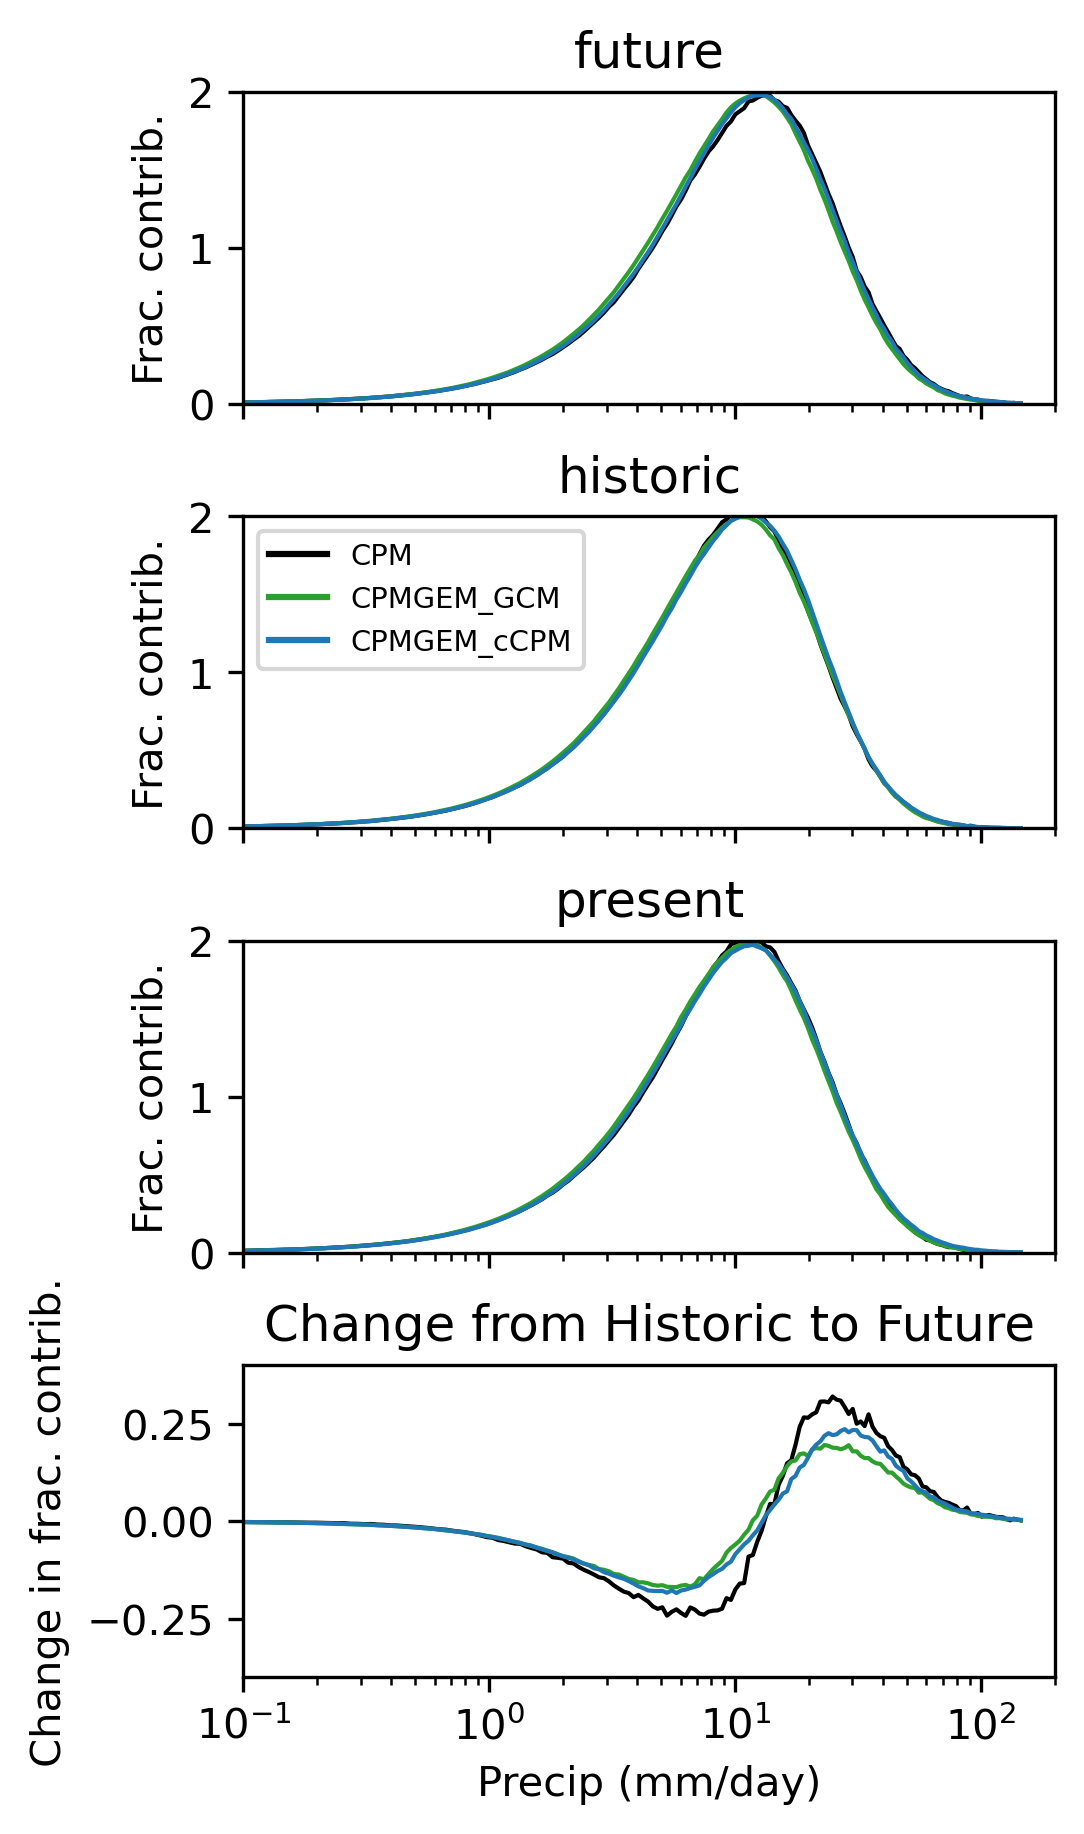

#### JJA

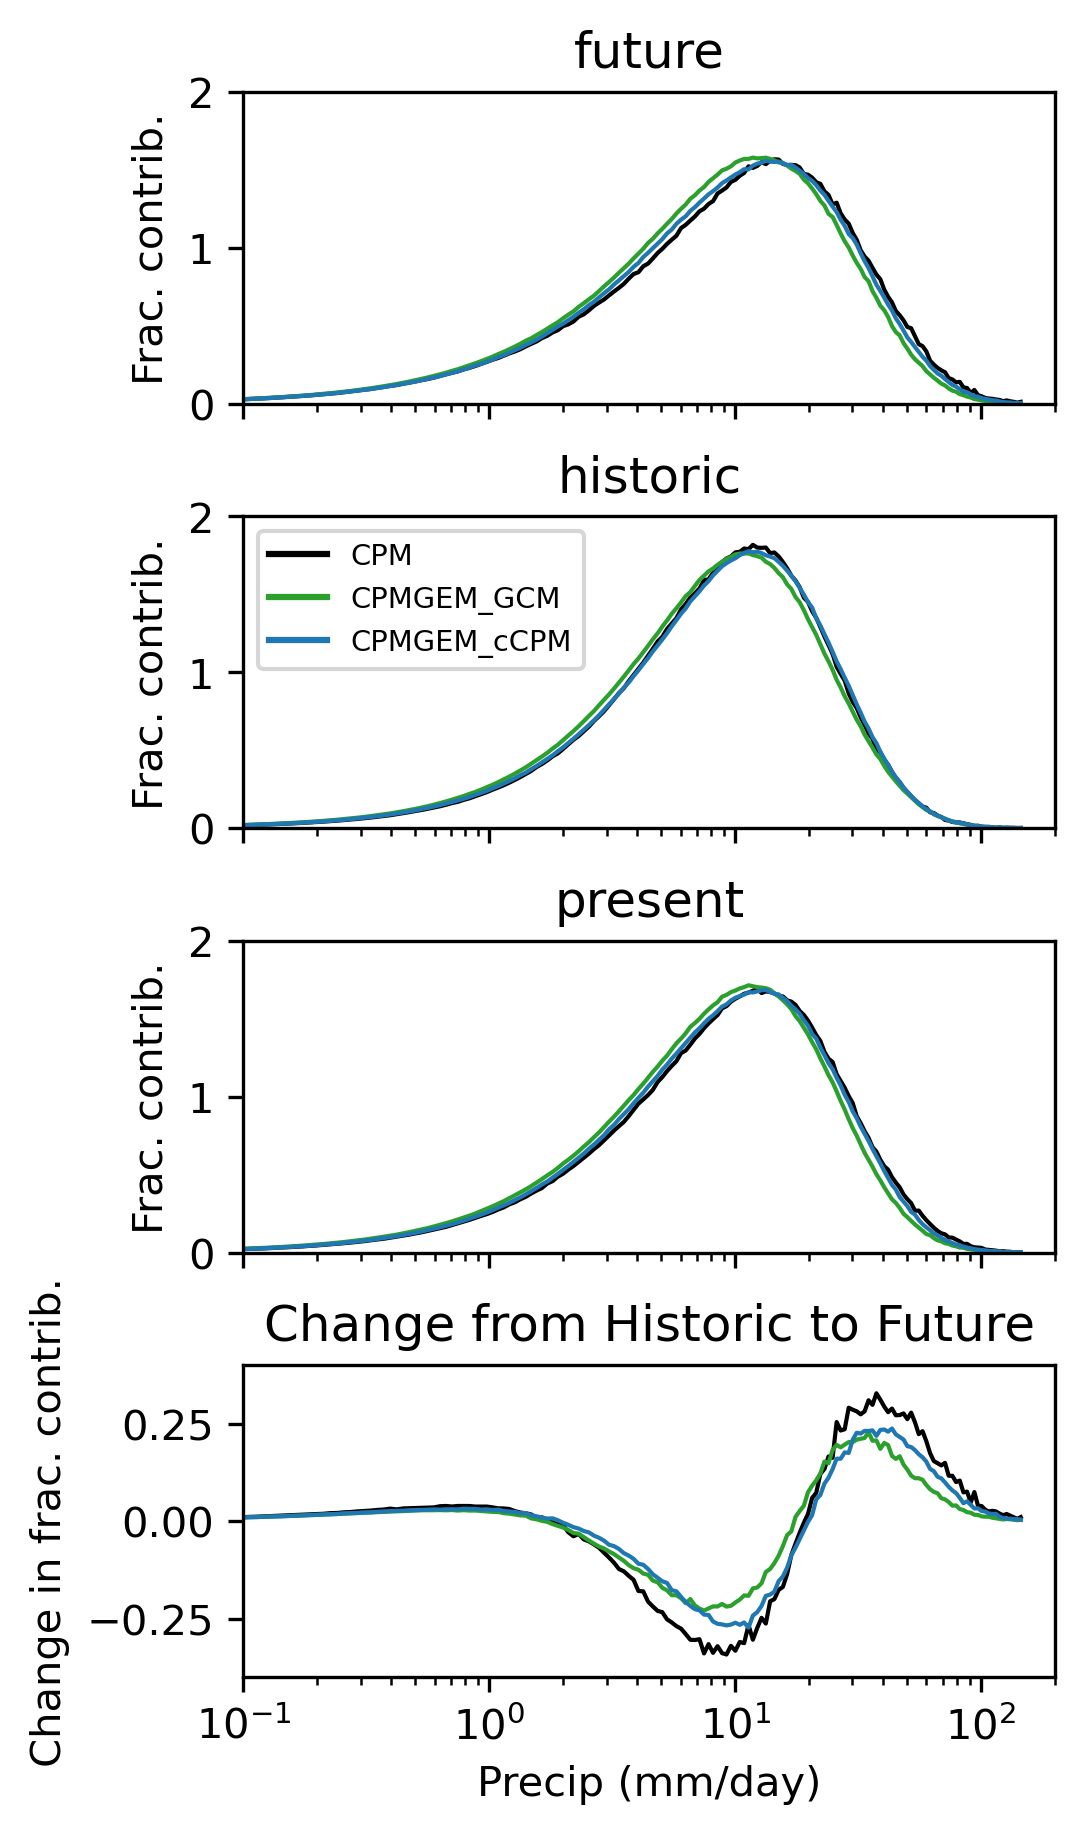

In [10]:
for var in eval_vars:
    if var not in ["pr"]:
        continue

    fcdata = ccs_fc_da(CCS_DS[f"pred_{var}"], CCS_DS[f"target_{var}"], extra_pred_dims=["time.season"], extra_cpm_dims=["time.season"])
    
    for season, season_fc in fcdata.groupby("season"):
        if season not in CCS_SEASONS:
            continue

        IPython.display.display_markdown(f"#### {season}", raw=True)

        
        fig = plt.figure(layout='constrained', figsize=(3.5, 6))
        plot_ccs_fc_figure(fig, season_fc, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()})
        plt.show()

### Bootstrapped per season fractional contribution

#### DJF

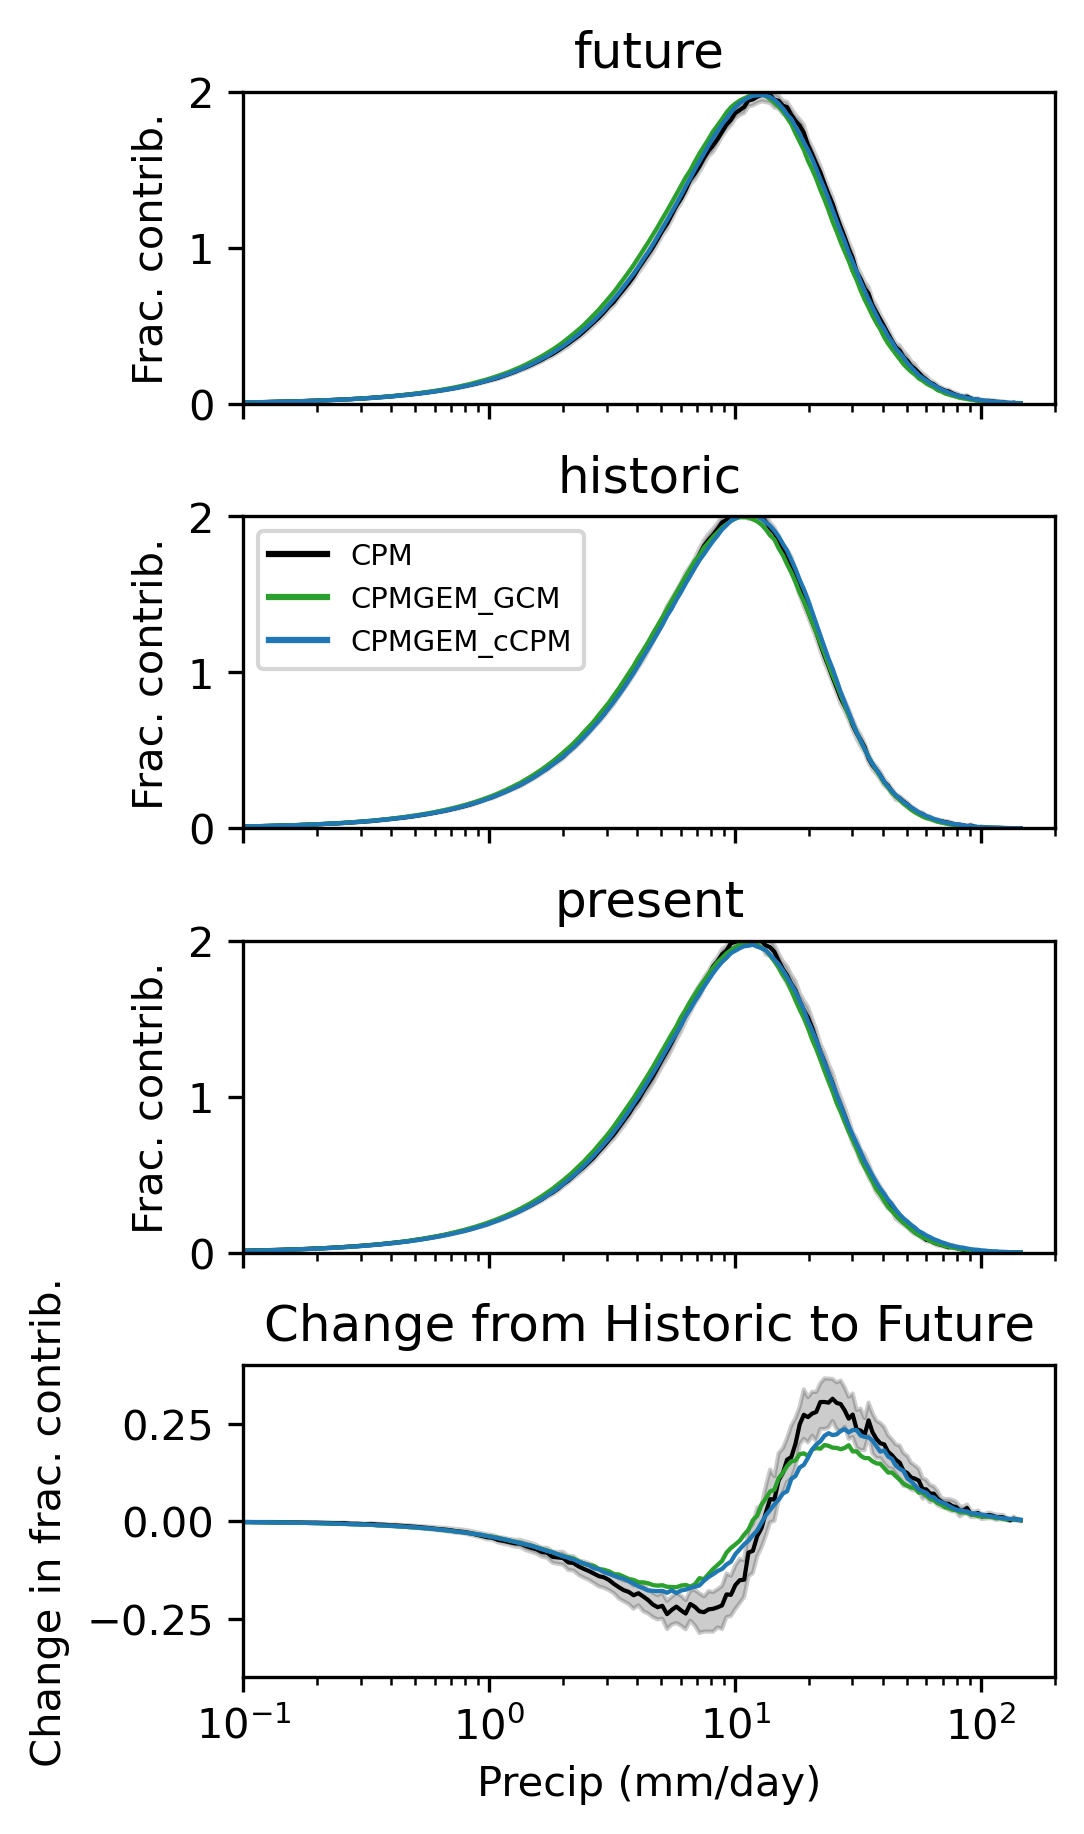

#### JJA

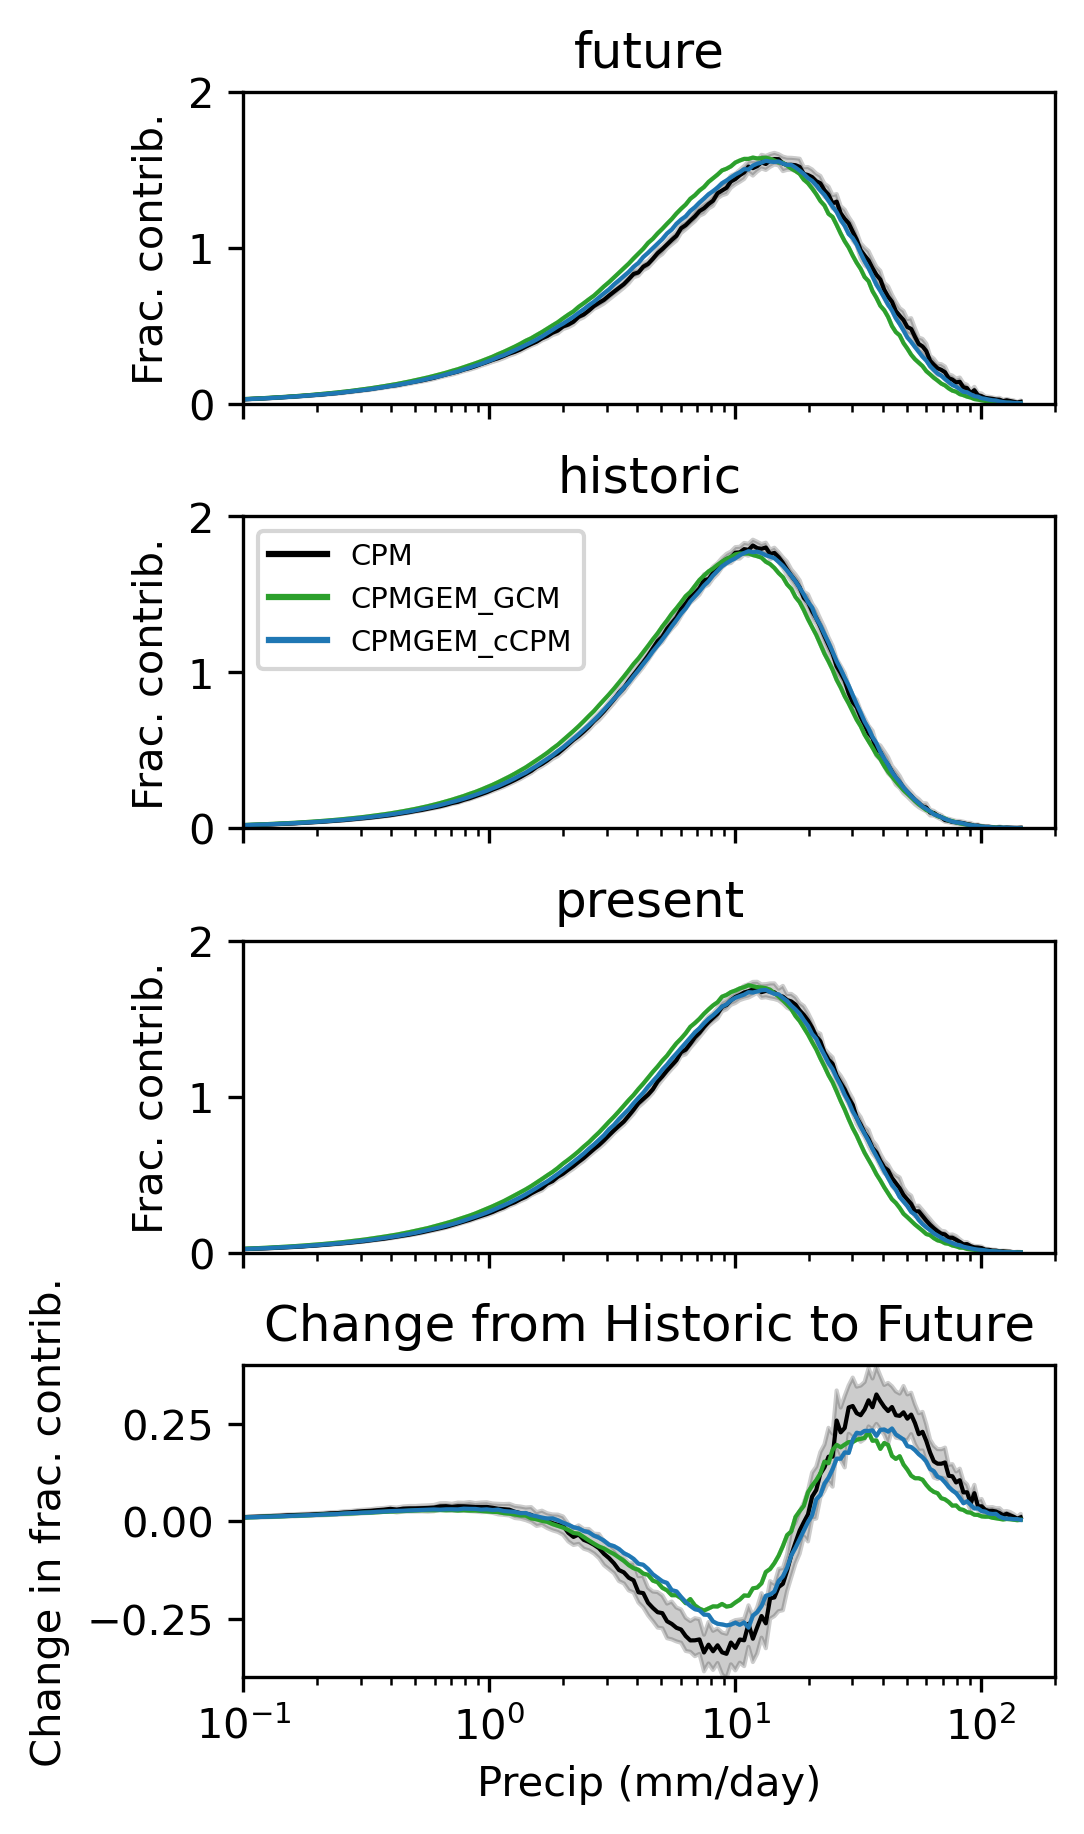

In [11]:
for var in eval_vars:
    if var not in ["pr"]:
        continue

    for season, season_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue
        IPython.display.display_markdown(f"#### {season}", raw=True)
        
        bs_cpm_da = chained_groupby_map(season_ds[f"target_{var}"], ["time_period"], resample_examples, niterations=niterations)

        # fcdata = ccs_fc_da(season_ds[f"pred_{var}"], bs_cpm_da, extra_pred_dims=[], extra_cpm_dims=["iteration"])
        fcdata = ccs_fc_da(season_ds[f"pred_{var}"], bs_cpm_da, extra_cpm_dims=["iteration"])
        
        fig = plt.figure(layout='constrained', figsize=(3.5, 6))
        plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()}, errorbar=("pi", 90))
        plt.show()        

#### DJF

##### CPMGEM_GCM

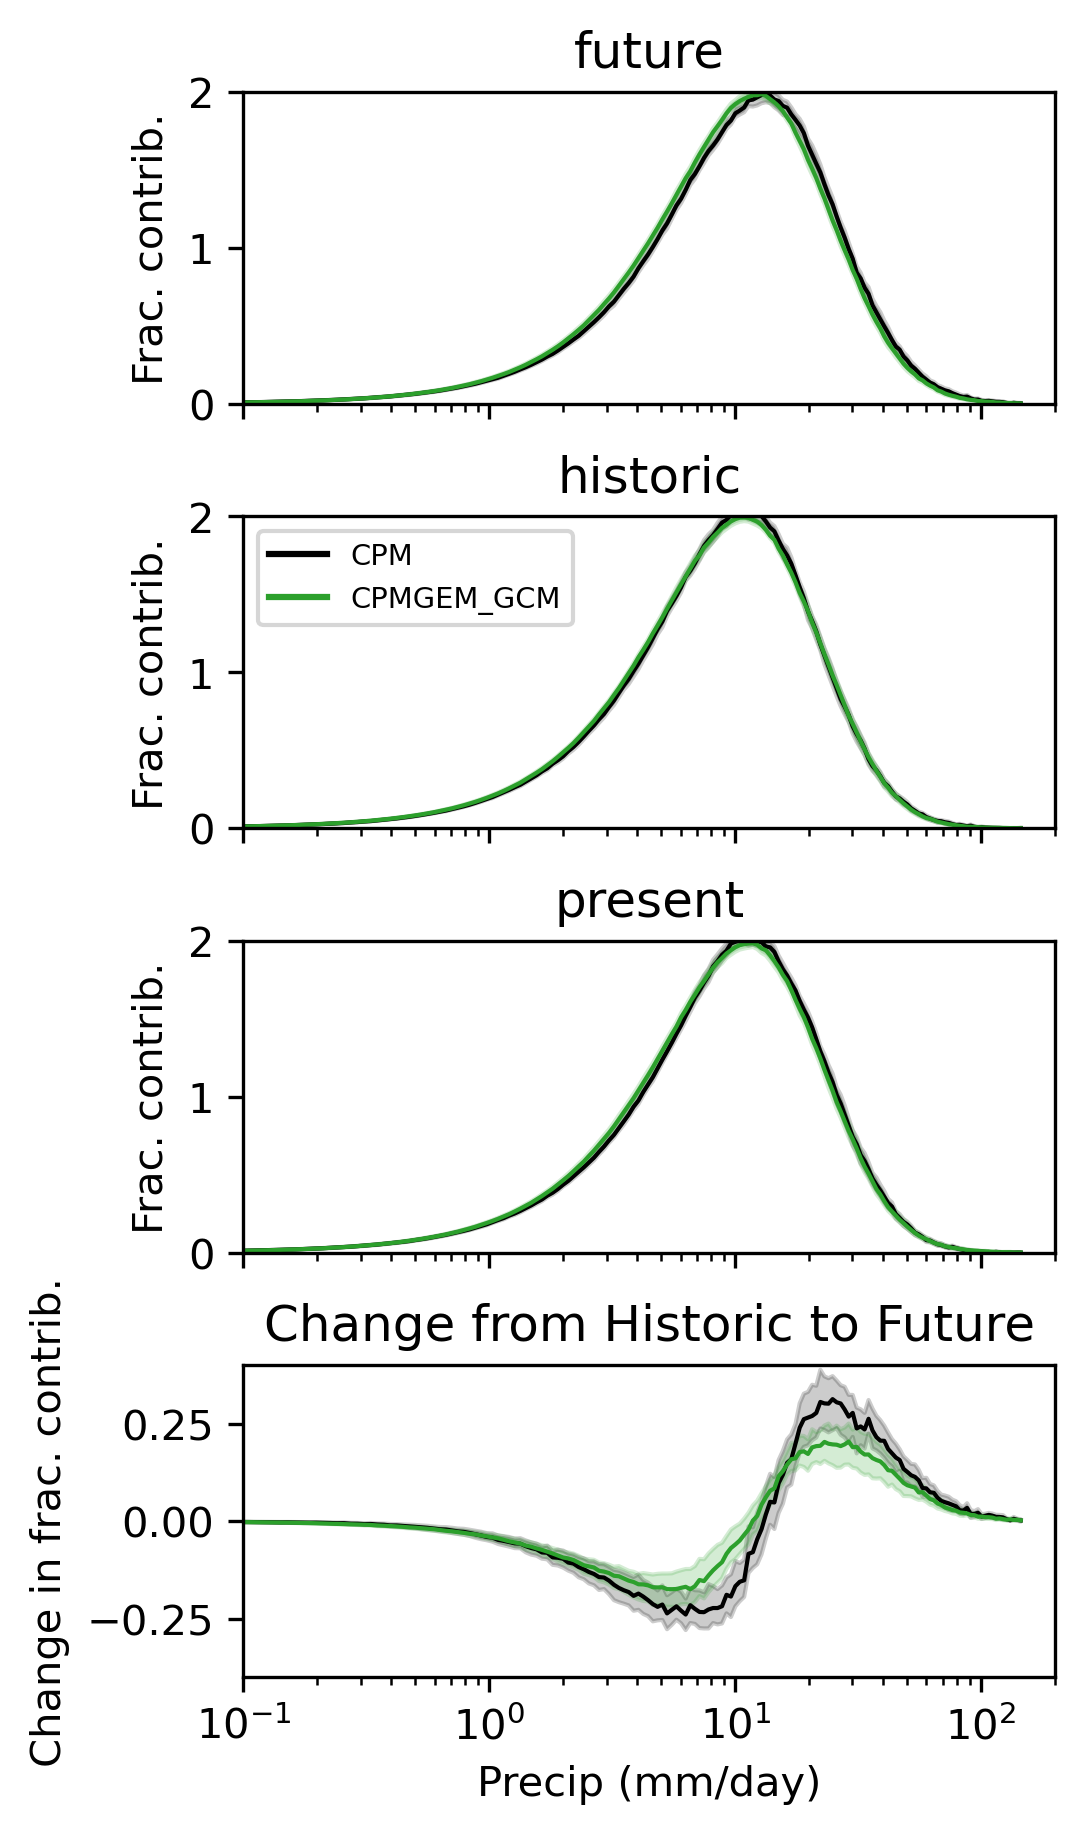

##### CPMGEM_cCPM

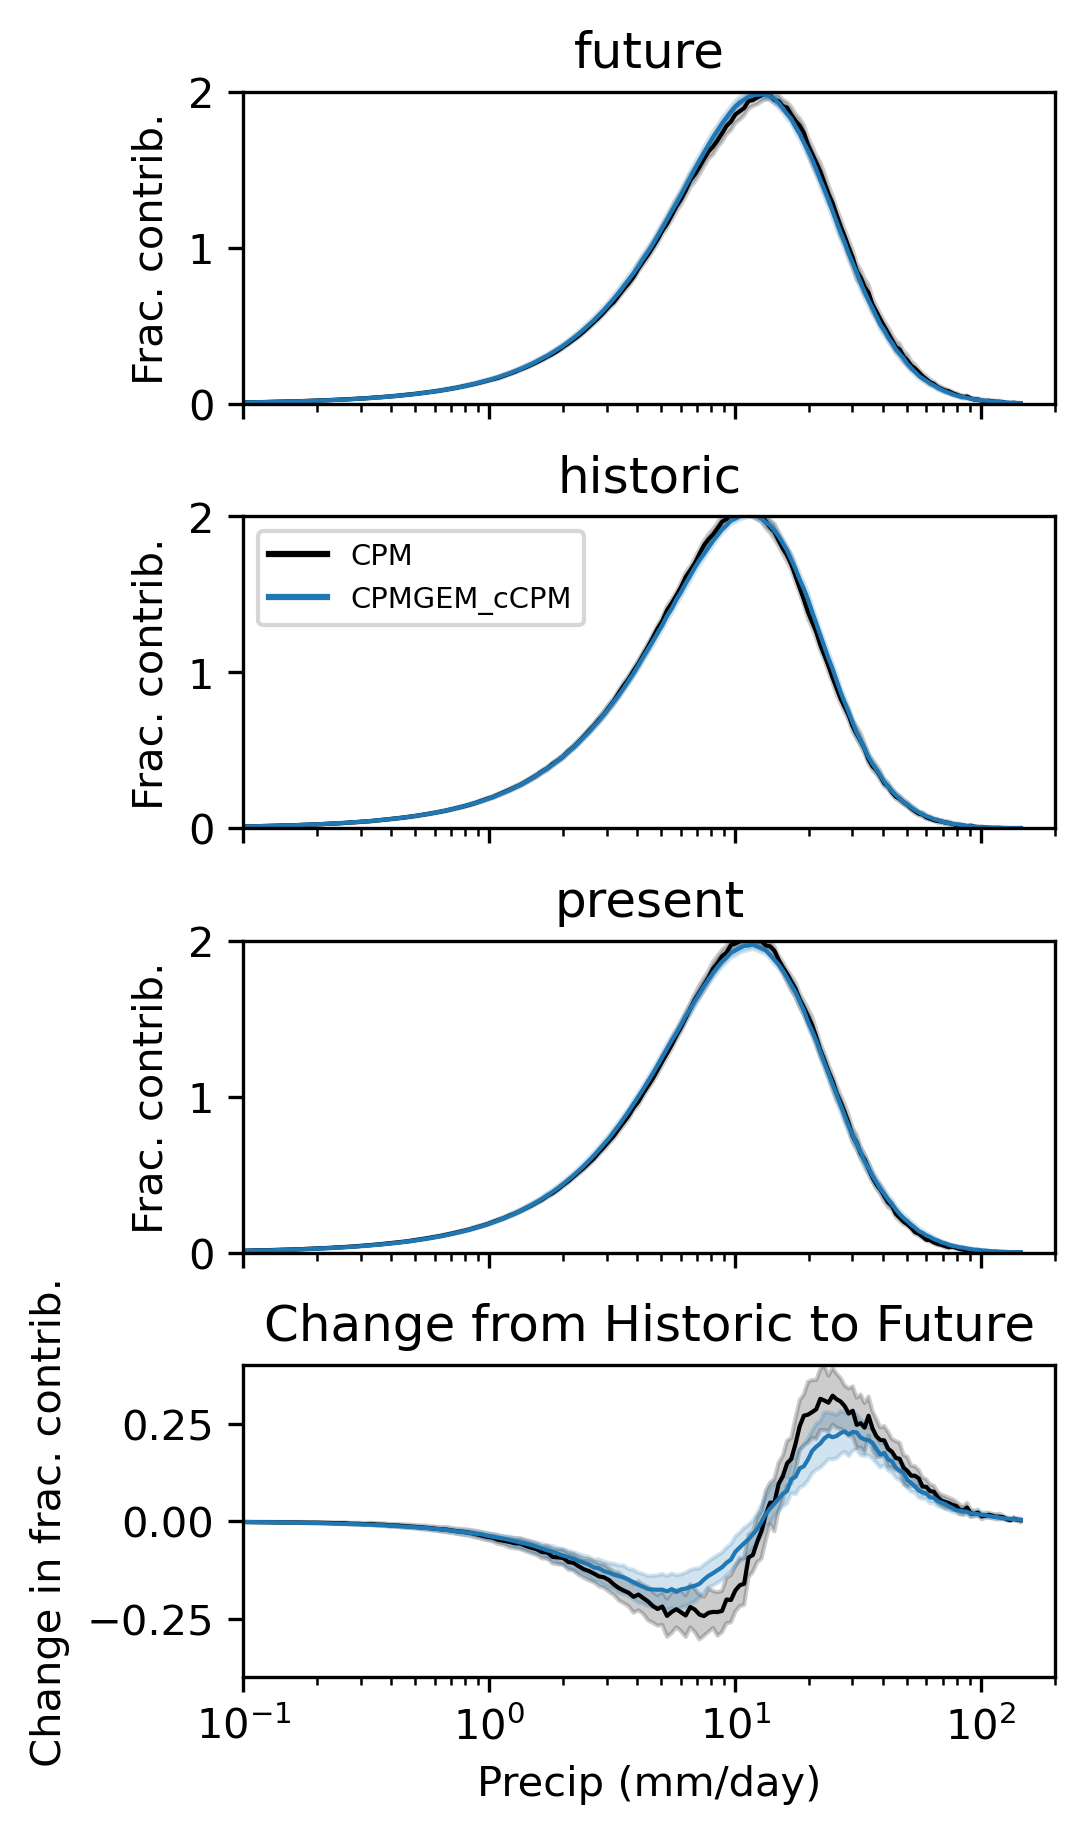

#### JJA

##### CPMGEM_GCM

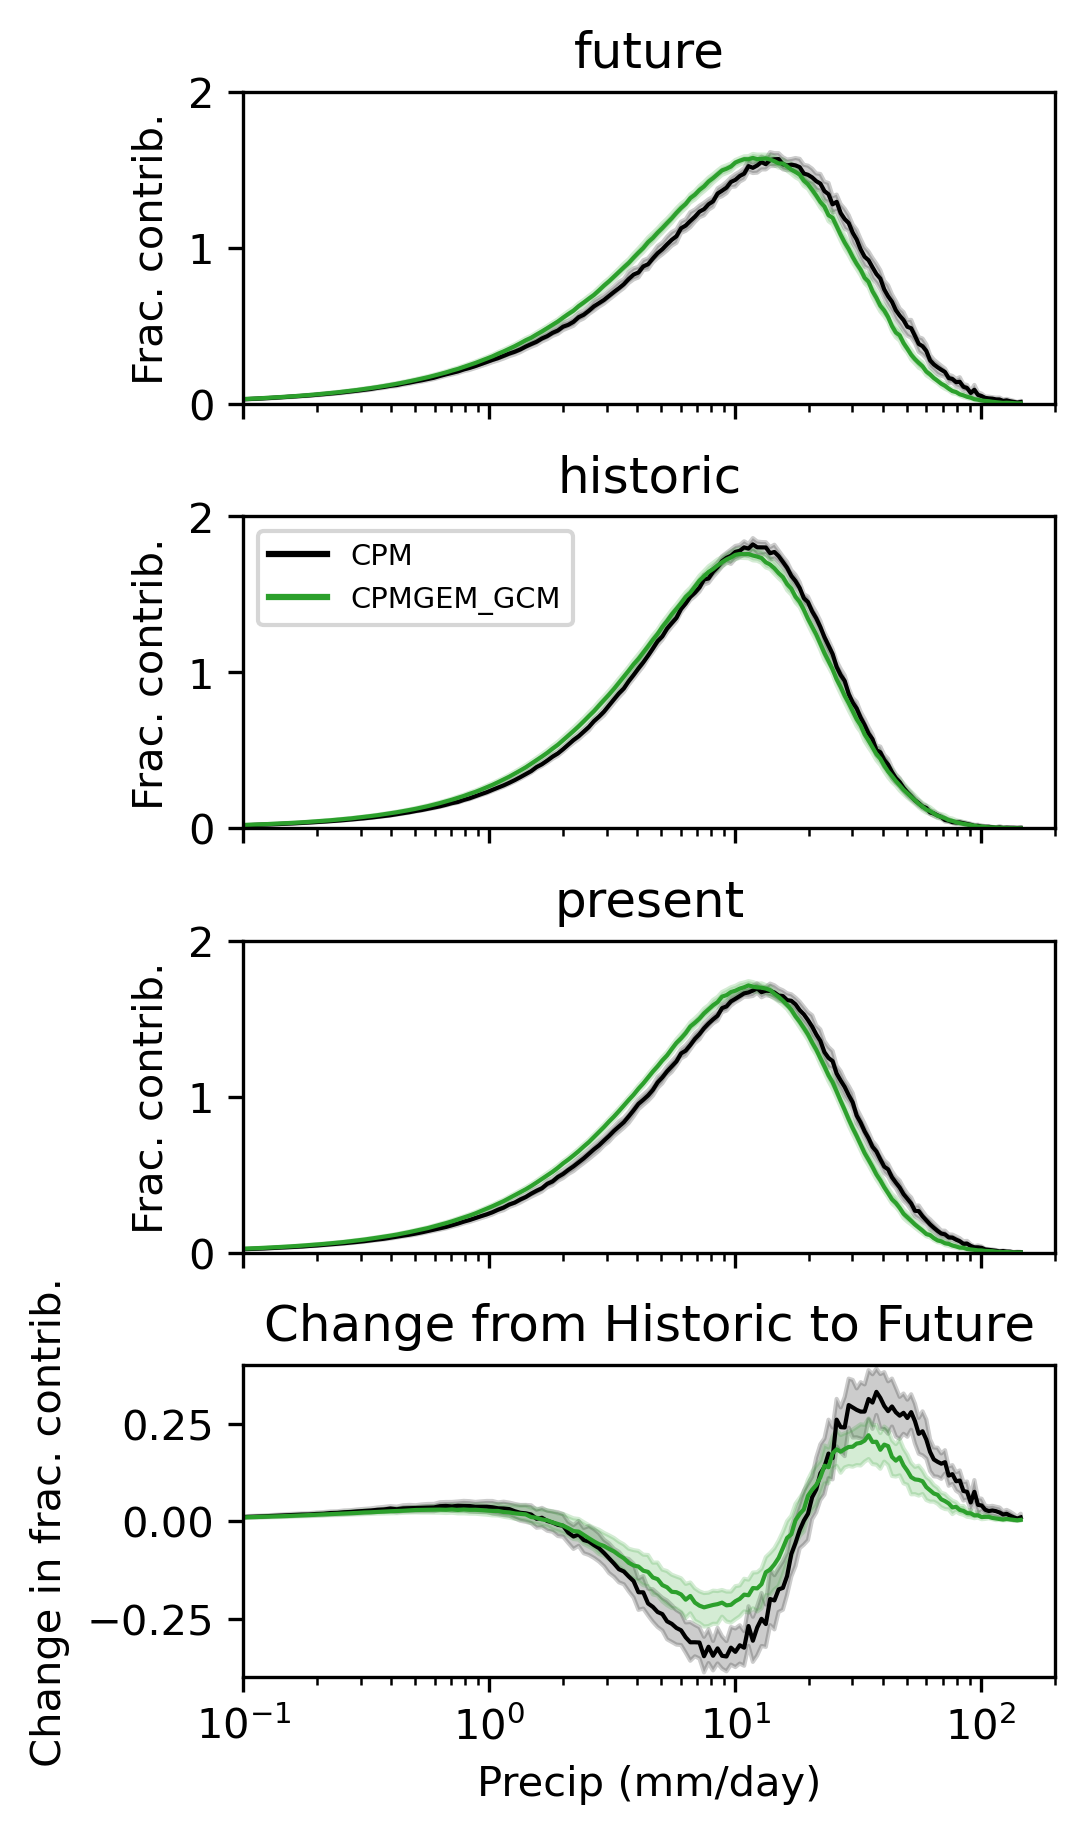

##### CPMGEM_cCPM

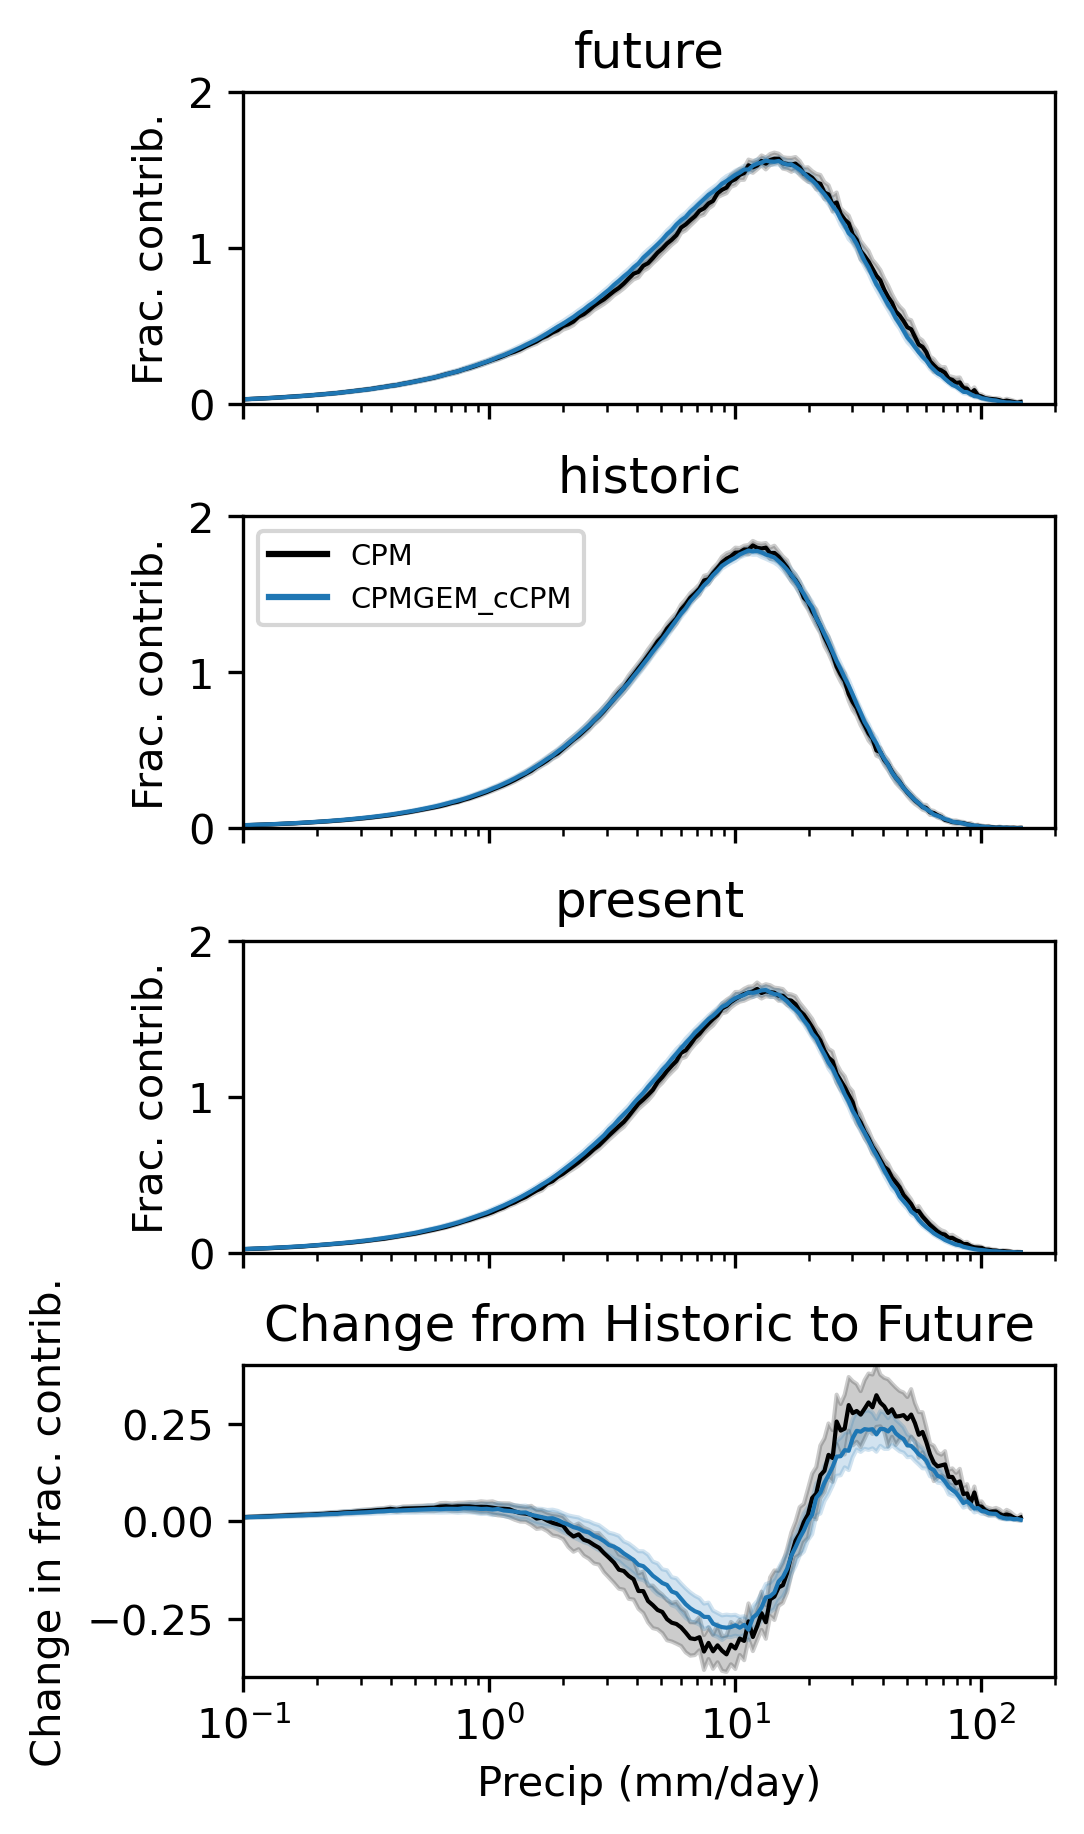

In [12]:
for var in eval_vars:
    if var not in ["pr"]:
        continue
    for season, season_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue
        IPython.display.display_markdown(f"#### {season}", raw=True)
        
        for model, model_pred_da in season_ds[f"pred_{var}"].groupby("model", squeeze=False):

            IPython.display.display_markdown(f"##### {model}", raw=True)    
            
            bs_cpm_da = chained_groupby_map(season_ds[f"target_{var}"], ["time_period"], resample_examples, niterations=niterations)
            bs_pred_da = chained_groupby_map(model_pred_da.squeeze("model"), ["time_period"], resample_examples, niterations=niterations)
    
            fcdata = ccs_fc_da(bs_pred_da.expand_dims(model=[model]), bs_cpm_da, extra_pred_dims=["iteration"], extra_cpm_dims=["iteration"])
            
            fig = plt.figure(layout='constrained', figsize=(3.5, 6))
            plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()}, errorbar=("pi", 90))
            plt.show()

#### DJF

##### CPMGEM_GCM

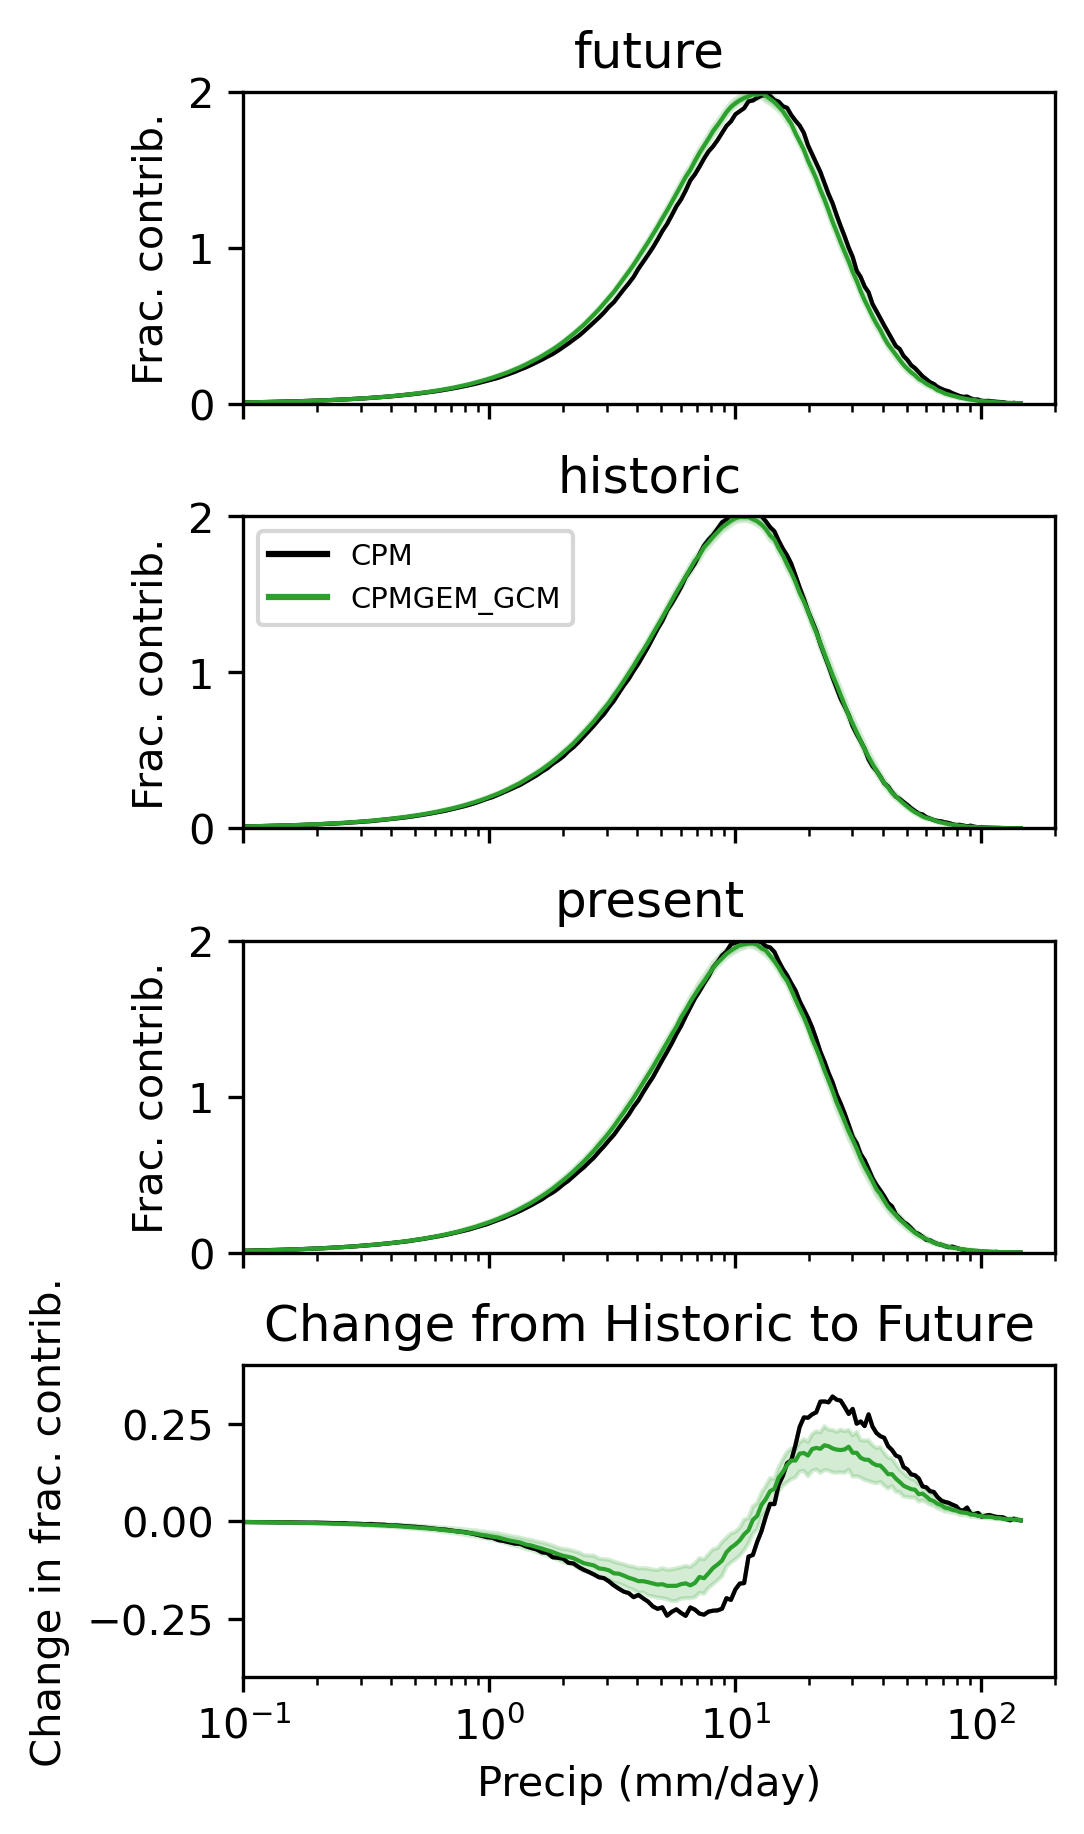

In [13]:
for var in eval_vars:
    if var not in ["pr"]:
        continue
    for season, season_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue
        IPython.display.display_markdown(f"#### {season}", raw=True)
        
        for model, model_pred_da in season_ds[f"pred_{var}"].groupby("model", squeeze=False):

            IPython.display.display_markdown(f"##### {model}", raw=True)    
    
            bs_pred_da = chained_groupby_map(model_pred_da.squeeze("model"), ["time_period"], resample_examples, niterations=niterations)
    
            fcdata = ccs_fc_da(bs_pred_da.expand_dims(model=[model]), season_ds[f"target_{var}"], extra_pred_dims=["iteration"])
            
            fig = plt.figure(layout='constrained', figsize=(3.5, 6))
            plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()}, errorbar=("pi", 90))
            plt.show()